In [1]:
from music21 import *
import glob
import numpy as np
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import History, ModelCheckpoint
from keras.optimizers import RMSprop
from datetime import datetime

/home/eurismar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/eurismar/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#path = '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/'
path = '/home/eurismar/notebooks/Classical-Piano-Composer/midi_songs'
#path = '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI'
#path = '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/chopin'

In [13]:
files = glob.glob('{}/*.mid*'.format(path))

In [14]:
files

['/home/eurismar/notebooks/Classical-Piano-Composer/midi_songs/ff4-airship.mid',
 '/home/eurismar/notebooks/Classical-Piano-Composer/midi_songs/Fiend_Battle_(Piano).mid',
 '/home/eurismar/notebooks/Classical-Piano-Composer/midi_songs/FFX_-_Ending_Theme_(Piano_Version)_-_by_Angel_FF.mid',
 '/home/eurismar/notebooks/Classical-Piano-Composer/midi_songs/electric_de_chocobo.mid',
 '/home/eurismar/notebooks/Classical-Piano-Composer/midi_songs/Fierce_Battle_(Piano).mid',
 '/home/eurismar/notebooks/Classical-Piano-Composer/midi_songs/Kingdom_Hearts_Dearly_Beloved.mid',
 '/home/eurismar/notebooks/Classical-Piano-Composer/midi_songs/pkelite4.mid',
 '/home/eurismar/notebooks/Classical-Piano-Composer/midi_songs/cosmo.mid',
 '/home/eurismar/notebooks/Classical-Piano-Composer/midi_songs/FF3_Battle_(Piano).mid',
 '/home/eurismar/notebooks/Classical-Piano-Composer/midi_songs/AT.mid',
 '/home/eurismar/notebooks/Classical-Piano-Composer/midi_songs/DOS.mid',
 '/home/eurismar/notebooks/Classical-Piano-Com

In [19]:
notes = []
melody_corpus = []
for file in files:
    midi = converter.parse(file)
    notes_to_parse = None

    try: # file has instrument parts
        s2 = instrument.partitionByInstrument(midi)
        notes_to_parse = s2.parts[0].recurse() 
    except: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
            note_repr = (str(element.pitch),element.quarterLength)
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
            note_repr = ('.'.join(str(n) for n in element.normalOrder),element.quarterLength)
        melody_corpus.append(note_repr)

In [20]:
melody_corpus

[(0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 (0, 1.0),
 ('7.11.2', 1.75),
 ('7', 0.5),
 ('7', 0.5),
 ('7', 0.5),
 ('7', 0.5),
 ('G5', 0.75),
 ('7', 0.5),
 ('7', 0.5),
 ('A3', 0.75),
 ('5', 0.5),
 ('5', 0.5),
 ('5.7', 0.75),
 ('3', 0.5),
 ('3', 0.5),
 ('E-5', 0.75),
 ('3', 0.5),
 ('3', 0.5),
 ('2.3.7', 0.75),
 ('3', 0.5),
 ('3', 0.5),
 ('C5', 0.75),
 ('3', 0.5),
 ('3', 0.5),
 ('10.2.5', 1.75),
 ('10', 0.5),
 ('10', 0.5),
 ('10', 0.5),
 ('10', 0.5),
 ('10.0', 0.75),
 ('10', 0.5),
 ('10', 0.5),
 ('D5', 0.75),
 ('10', 0.5),
 ('10', 0.5),
 ('0.5', 6.75),
 ('G#4', 3.75),
 ('5', 0.5),
 ('5', 0.5),
 ('5', 0.5),
 ('5', 0.5),
 ('5', 0.5),
 ('5', 0.5),
 ('5', 0.5),
 ('5', 0.5),
 ('5', 0.5),
 ('5', 0.5),
 ('7', 0.5),
 ('7', 0.5),
 ('8', 0.5),
 ('8', 0.5),
 ('5.10', 0.75),
 ('10', 0.5),
 ('10', 0.5),
 ('0.4.7', 3.75),
 ('0', 0.5),
 ('0', 0.5),
 ('0', 0.5),
 ('0', 0.5),
 ('0', 0.5),
 ('0', 0.5),
 ('0', 0.5),
 ('0', 0.5),
 ('C6', 0.25),
 ('0', 0.5),
 ('G5', 0.25),
 ('E5', 0.25),
 ('0', 0.5),
 ('C5', 

In [15]:
KEY_SIG_OFFSET = 0 
melody_corpus = []
for i, file in enumerate(files):
#for file in files:
    midi_stream = converter.parse(file)
    
    part0 = midi_stream[0]
    key_sig = part0.keySignature
    midi_stream.transpose(KEY_SIG_OFFSET - key_sig.tonic.pitchClass, inPlace=True)
    print(key_sig)
    for m in part0.measures(1, None):
        if hasattr(m, 'flat'):
            for nr in m.flat.notesAndRests:
                pitch = nr.pitch.midi  if isinstance(nr, note.Note) else 0
                duration = float(nr.quarterLength)
                note_repr = (pitch, duration)
                melody_corpus.append(note_repr)

C major
C major


meter.py: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


AttributeError: 'NoneType' object has no attribute 'tonic'

In [21]:
melody_set = set(melody_corpus)

In [22]:
notes_indices = {note: i for i, note in enumerate(melody_set)}
indices_notes = {i: note for i, note in enumerate(melody_set)}

In [23]:
corpus_size = len(melody_set)
print(corpus_size)

2597


In [24]:
phrase_len = 20
step_size = 3

In [25]:
phrases = []
next_notes = []

In [26]:
for i in range(0, len(melody_corpus) - phrase_len, step_size):
    phrases.append(melody_corpus[i: i + phrase_len])
    next_notes.append(melody_corpus[i + phrase_len])
print('nb sequences:', len(phrases))

nb sequences: 22993


In [27]:
# transform data into binary matrices
X = np.zeros((len(phrases), phrase_len, corpus_size), dtype=np.bool)
y = np.zeros((len(phrases), corpus_size), dtype=np.bool)
print(X.shape)
print(y.shape)

(22993, 20, 2597)
(22993, 2597)


In [28]:
for i, phrase in enumerate(phrases):
    for j, note in enumerate(phrase):
        X[i, j, notes_indices[note]] = 1
    y[i, notes_indices[next_notes[i]]] = 1

In [29]:
layer_size=128
batch_size = 128
nb_epoch = 400

In [30]:
model = Sequential()
model.add(LSTM(layer_size, return_sequences=True, input_shape=(phrase_len, corpus_size)))
model.add(Dropout(0.2))
model.add(LSTM(layer_size, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(corpus_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 128)           1395712   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2597)              335013    
_________________________________________________________________
activation_1 (Activation)    (None, 2597)              0         
Total params: 1,862,309
Trainable params: 1,862,309
Non-trainable params: 0
_________________________________________________________________


### VERSAO 2

In [32]:
def get_model():
    LSTM_in = Input(shape=(phrase_len, corpus_size))
    layer = LSTM(layer_size, return_sequences=True)(LSTM_in)
    layer = Dropout(0.2)(layer)
    layer = LSTM(layer_size, return_sequences=False)(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(corpus_size)(layer)
    LSTM_out = Activation('softmax')(layer)
    m = Model(LSTM_in, LSTM_out)
    m.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    return m

In [33]:
history = History()

In [34]:
model.fit(X, y, batch_size=batch_size, epochs=nb_epoch, callbacks=[history])

Epoch 1/400
22993/22993 [==============================] - 42s - loss: 6.5180 - acc: 0.0155    
Epoch 2/400
22993/22993 [==============================] - 22s - loss: 6.0589 - acc: 0.0287    
Epoch 3/400
22993/22993 [==============================] - 21s - loss: 5.7712 - acc: 0.0510    
Epoch 4/400
22993/22993 [==============================] - 23s - loss: 5.5593 - acc: 0.0703    
Epoch 5/400
22993/22993 [==============================] - 21s - loss: 5.3738 - acc: 0.0912    
Epoch 6/400
22993/22993 [==============================] - 20s - loss: 5.2094 - acc: 0.1112    
Epoch 7/400
22993/22993 [==============================] - 21s - loss: 5.0650 - acc: 0.1273    
Epoch 8/400
22993/22993 [==============================] - 21s - loss: 4.9288 - acc: 0.1380    
Epoch 9/400
22993/22993 [==============================] - 21s - loss: 4.8084 - acc: 0.1514    
Epoch 10/400
22993/22993 [==============================] - 21s - loss: 4.6923 - acc: 0.1630    
Epoch 11/400
22993/22993 [=============

22993/22993 [==============================] - 22s - loss: 2.2141 - acc: 0.6249    
Epoch 86/400
22993/22993 [==============================] - 21s - loss: 2.1962 - acc: 0.6283    
Epoch 87/400
22993/22993 [==============================] - 21s - loss: 2.1869 - acc: 0.6290    
Epoch 88/400
22993/22993 [==============================] - 21s - loss: 2.1698 - acc: 0.6366    
Epoch 89/400
22993/22993 [==============================] - 21s - loss: 2.1523 - acc: 0.6392    
Epoch 90/400
22993/22993 [==============================] - 22s - loss: 2.1402 - acc: 0.6455    
Epoch 91/400
22993/22993 [==============================] - 21s - loss: 2.1283 - acc: 0.6456    
Epoch 92/400
22993/22993 [==============================] - 21s - loss: 2.1248 - acc: 0.6455    
Epoch 93/400
22993/22993 [==============================] - 21s - loss: 2.1054 - acc: 0.6498    
Epoch 94/400
22993/22993 [==============================] - 21s - loss: 2.0920 - acc: 0.6506    
Epoch 95/400
22993/22993 [=================

22993/22993 [==============================] - 21s - loss: 1.5776 - acc: 0.7729    
Epoch 169/400
22993/22993 [==============================] - 21s - loss: 1.5778 - acc: 0.7746    
Epoch 170/400
22993/22993 [==============================] - 22s - loss: 1.5603 - acc: 0.7773    
Epoch 171/400
22993/22993 [==============================] - 21s - loss: 1.5638 - acc: 0.7768    
Epoch 172/400
22993/22993 [==============================] - 21s - loss: 1.5641 - acc: 0.7778    
Epoch 173/400
22993/22993 [==============================] - 21s - loss: 1.5562 - acc: 0.7788    
Epoch 174/400
22993/22993 [==============================] - 21s - loss: 1.5559 - acc: 0.7802    
Epoch 175/400
22993/22993 [==============================] - 21s - loss: 1.5520 - acc: 0.7805    
Epoch 176/400
22993/22993 [==============================] - 21s - loss: 1.5455 - acc: 0.7822    
Epoch 177/400
22993/22993 [==============================] - 21s - loss: 1.5404 - acc: 0.7837    
Epoch 178/400
22993/22993 [=======

22993/22993 [==============================] - 21s - loss: 1.3303 - acc: 0.8260    
Epoch 252/400
22993/22993 [==============================] - 21s - loss: 1.3324 - acc: 0.8236    
Epoch 253/400
22993/22993 [==============================] - 21s - loss: 1.3259 - acc: 0.8279    
Epoch 254/400
22993/22993 [==============================] - 21s - loss: 1.3255 - acc: 0.8279    
Epoch 255/400
22993/22993 [==============================] - 21s - loss: 1.3193 - acc: 0.8277    
Epoch 256/400
22993/22993 [==============================] - 21s - loss: 1.3168 - acc: 0.8276    
Epoch 257/400
22993/22993 [==============================] - 21s - loss: 1.3146 - acc: 0.8299    
Epoch 258/400
22993/22993 [==============================] - 21s - loss: 1.3118 - acc: 0.8279    
Epoch 259/400
22993/22993 [==============================] - 21s - loss: 1.3144 - acc: 0.8286    
Epoch 260/400
22993/22993 [==============================] - 21s - loss: 1.3141 - acc: 0.8285    
Epoch 261/400
22993/22993 [=======

22993/22993 [==============================] - 23s - loss: 1.1966 - acc: 0.8486    
Epoch 335/400
22993/22993 [==============================] - 23s - loss: 1.1916 - acc: 0.8482    
Epoch 336/400
22993/22993 [==============================] - 24s - loss: 1.1884 - acc: 0.8499    
Epoch 337/400
22993/22993 [==============================] - 23s - loss: 1.1913 - acc: 0.8501    
Epoch 338/400
22993/22993 [==============================] - 23s - loss: 1.1829 - acc: 0.8513    
Epoch 339/400
22993/22993 [==============================] - 22s - loss: 1.1831 - acc: 0.8528    
Epoch 340/400
22993/22993 [==============================] - 23s - loss: 1.1842 - acc: 0.8537    
Epoch 341/400
22993/22993 [==============================] - 22s - loss: 1.1822 - acc: 0.8514    
Epoch 342/400
22993/22993 [==============================] - 21s - loss: 1.1778 - acc: 0.8530    
Epoch 343/400
22993/22993 [==============================] - 21s - loss: 1.1789 - acc: 0.8495    
Epoch 344/400
22993/22993 [=======

In [35]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'acc'])


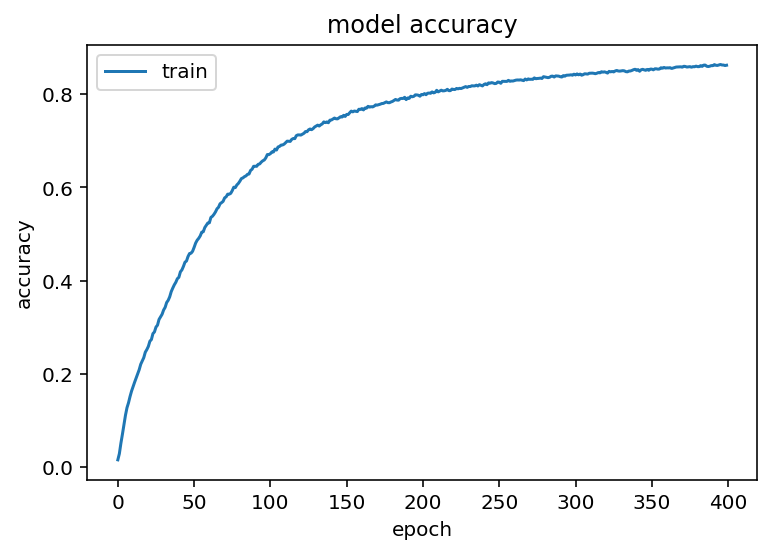

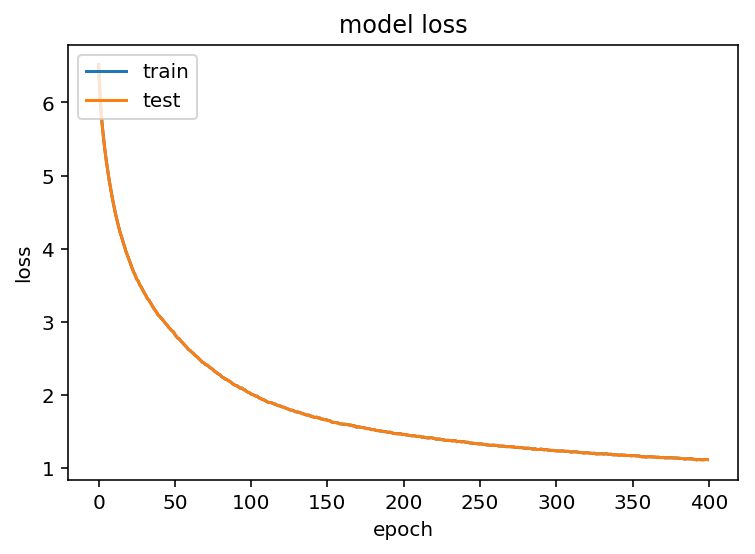

In [36]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [37]:
gen_melody_indices = np.zeros((1, phrase_len, len(melody_set)))
print(gen_melody_indices.shape)

(1, 20, 2597)


In [38]:
start_pos = np.random.randint(0, len(melody_corpus) - phrase_len)

In [39]:
seed_phrase = melody_corpus[start_pos : start_pos + phrase_len]

In [40]:
gen_melody = seed_phrase

In [52]:
seq_len = 100

In [132]:
start = np.random.randint(0, len(phrases)-1)
pattern = phrases[start]
#print('pattern original:')
#print(pattern)
nova_sequencia = []
for i in range(seq_len):
    gen_melody_indices = np.zeros((1, phrase_len, len(melody_set)))
    for j, note in enumerate(pattern):
        gen_melody_indices[0, j, notes_indices[note]] = 1
    x = gen_melody_indices
    prediction = model.predict(x, verbose=0)[0]
    index = np.argmax(prediction)
    result = indices_notes[index]
    #print('result:',result)
    nova_sequencia.append(result)
    pattern.append(result)
    pattern = pattern[1:len(pattern)]
    #print('pattern {}:'.format(i))
    #print(pattern)

In [133]:
nova_sequencia

[('9.2', 0.5),
 ('9.2', 0.5),
 ('4', 0.5),
 ('4', 0.5),
 ('2', 0.5),
 ('B4', 0.25),
 ('2', 0.5),
 ('2', 0.5),
 ('2', 0.5),
 ('2', 0.5),
 ('2', 0.5),
 ('9', 0.5),
 ('9', 0.5),
 ('9', 0.5),
 ('2', 0.5),
 ('2', 0.5),
 ('7.11', 0.5),
 ('2', 0.5),
 ('11', 0.5),
 ('G4', 0.5),
 ('A3', 0.5),
 ('2', 0.5),
 ('7', 0.5),
 ('7', 0.5),
 ('2', 0.5),
 ('2', 0.5),
 ('D3', 0.5),
 ('2', 0.5),
 ('0.3', 0.5),
 ('F4', 0.5),
 ('4', 0.5),
 ('9', 0.5),
 ('9', 0.5),
 ('2', 0.5),
 ('2', 0.5),
 ('2', 0.5),
 ('G4', 0.5),
 ('C3', 0.5),
 ('E-2', 0.5),
 ('B-4', 0.25),
 ('9', 0.5),
 ('E-2', 0.5),
 ('E-2', 0.5),
 ('E-2', 0.5),
 ('A4', 0.25),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D3', 0.5),
 ('D5', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('G3', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('D2', 0.5),
 ('G3', 0.5),
 ('G3', 0.5),
 ('G3', 0.5),
 ('G3'

In [134]:
from music21 import *

In [135]:
output_notes = []
sc = stream.Score()
for t in nova_sequencia:
      if t[0] == 0.0:
        r = note.Rest(quarterLength = 0.25)
        sc.append(r)
      elif ('.' in t[0]) or t[0].isdigit():
          notes_in_chord = t[0].split('.')
          #print(notes_in_chord)
          notes = []
          for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            notes.append(new_note)
          new_chord = chord.Chord(notes,quarterLength=t[1])
          #new_chord.offset = offset
          output_notes.append(new_chord)
          sc.append(new_chord)
      else:
          new_note = note.Note(t[0],quarterLength=t[1])
          output_notes.append(new_note)
          
          sc.append(new_note)
          #n = note.Note(midi=t[0], quarterLength=t[1])
        #output_notes.append(n)
#print(output_notes)
midi_stream = stream.Stream(output_notes)
          

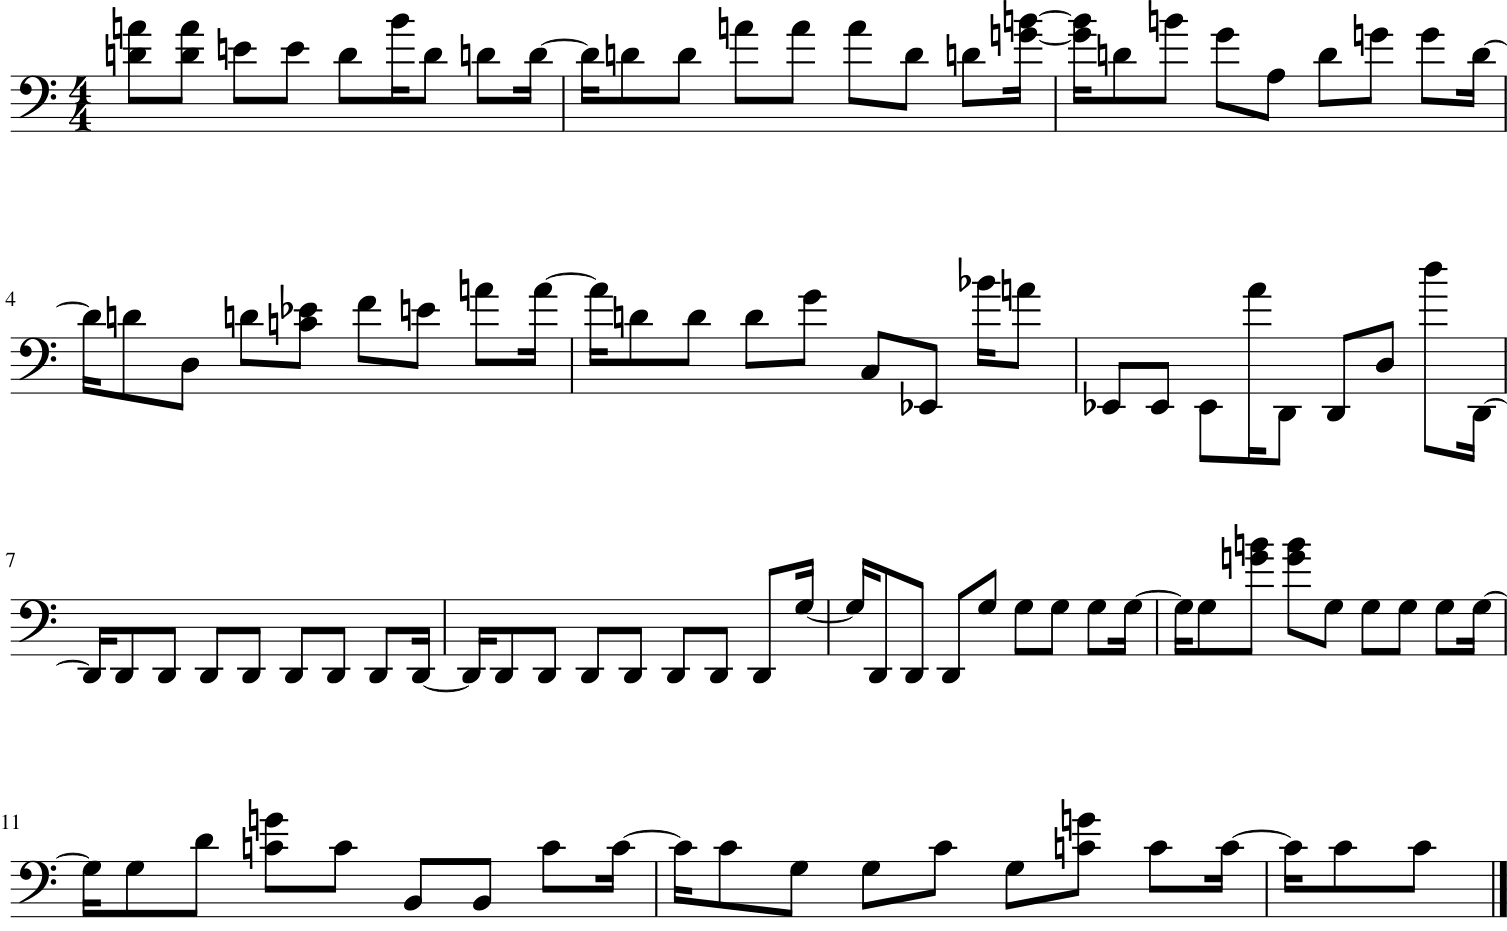

In [136]:
midi_stream.show()

In [137]:
midi_stream.show('text')

{0.0} <music21.chord.Chord A D>
{0.5} <music21.chord.Chord A D>
{1.0} <music21.chord.Chord E>
{1.5} <music21.chord.Chord E>
{2.0} <music21.chord.Chord D>
{2.5} <music21.note.Note B>
{2.75} <music21.chord.Chord D>
{3.25} <music21.chord.Chord D>
{3.75} <music21.chord.Chord D>
{4.25} <music21.chord.Chord D>
{4.75} <music21.chord.Chord D>
{5.25} <music21.chord.Chord A>
{5.75} <music21.chord.Chord A>
{6.25} <music21.chord.Chord A>
{6.75} <music21.chord.Chord D>
{7.25} <music21.chord.Chord D>
{7.75} <music21.chord.Chord G B>
{8.25} <music21.chord.Chord D>
{8.75} <music21.chord.Chord B>
{9.25} <music21.note.Note G>
{9.75} <music21.note.Note A>
{10.25} <music21.chord.Chord D>
{10.75} <music21.chord.Chord G>
{11.25} <music21.chord.Chord G>
{11.75} <music21.chord.Chord D>
{12.25} <music21.chord.Chord D>
{12.75} <music21.note.Note D>
{13.25} <music21.chord.Chord D>
{13.75} <music21.chord.Chord C E->
{14.25} <music21.note.Note F>
{14.75} <music21.chord.Chord E>
{15.25} <music21.chord.Chord A>
{15.

In [138]:
filename = "gerada_" + datetime.now().strftime("%Y%m%d-%H%M%S"+".mid")

In [139]:
print(filename)

gerada_20180711-022049.mid


In [140]:
from music21 import *
mf = midi.translate.streamToMidiFile(sc)
mf.open(filename, 'wb')
mf.write()
mf.close()

In [141]:
!pwd

/home/eurismar/notebooks/JohaNN


In [143]:
model.save_weights('lstm_music21_corpus_4.hdf5')

In [144]:
!ls lstm_music21_corpus_4.hdf5

lstm_music21_corpus_4.hdf5
